# Karachi is a coastal town in Pakistan,that suffered severe flooding in August 2020. The main dates of the flooding were 25 August 2020 - 27 August 2020, but we expect to see impact well beyond that. 

## Install rioxarray package

In [2]:
%%capture

!pip install rioxarray

# Connect the notebook to your Google drive. 

A link will appear, click on it, and follow the instructions to connect an account. Copy the code that appears at the end of this process, and paste in the box below.

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Required Modules

In [4]:
import numpy as np
import xarray as xa
import rioxarray as riox

import folium
from folium import plugins
import matplotlib.pyplot as plt
from matplotlib import cm

## Define Functions

In [24]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_rgb_composite(raster):
    """Creates an RGB composite image using the input raster."""
    r = raster[2]
    g = raster[1]
    b = raster[0]
    n=1

    return make_composite(n*r/10000., n*g/10000., n*b/10000.)

def calculate_ndvi(raster):
    """Calculates the normalised difference vegetation index using the input raster."""
    r = raster[2]
    nir = raster[3]

    return (nir - r) / (nir + r)

def calculate_ndwi(raster):
    """Calculates the normalised difference water index using the input raster."""
    g = raster[1]
    nir = raster[3]

    return (g - nir) / (g + nir)

## Importing raster data using rioxarray

The image bands are (in order) Blue, Green, Red, Near IR, with the final layer containing a cloud probability map. A factor of 10^-4 scaling of the R, G, B and NIR bands is required to obtain true pixel value, as Google Earth Engine image pixel values are stored as integers to save on storage space.

Typically the [Rasterio](https://rasterio.readthedocs.io/en/latest/quickstart.html) package is used to open geoTIFF tiles in Python, however I personally prefer using the [Rioxarray](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) package as it enhances the capabilities of Rasterio and includes methods that simplifies a lot of the boilerplate code required when using Rasterio. Rioxarray imports the raster files into a `DataArray` format via the [xarray](http://xarray.pydata.org/en/stable/index.html) package, which is essentially a beefed up version of NumPy, incorporating many features from Pandas and for the most part can be treated like a standard NumPy `array`. Unfortunatley the main drawback of rioxarray over rasterio is a lack of documentation, however the xarray documentation itself is very comphrehensive.

To convert DataArrays to numpy array format simply apply the `.values` attribute on your data as you would when using Pandas.

Also of final note for the Shamshato region I would personally choose only scenes with size > 10MB as these scenes are most likely to be complete.



In [39]:
s2_filepath = "/content/drive/Shared drives/ICG Data Analytics/Data/Pakistan/Karachi/2020-08-01/Sentinel_2_SR/20200801T055641_20200801T061143_T42RUN.tif"

# Bands are (in order) Blue, Green, Red, Near IR, with the final layer 
# containing a cloud probability map. A factor of 10^-4 scaling of the R, G, B 
# and NIR bands is required to obtain true pixel value, as Google Earth Engine 
# image pixel values are stored as integers to save on storage space.

s2_raster = riox.open_rasterio(s2_filepath)[:-1]/10000. # Scaled R, G, B and NIR bands.
cloud_prob_map = riox.open_rasterio(s2_filepath)[-1] # Unscaled cloud probability map.

s2_raster

<xarray.DataArray (band: 4, y: 1427, x: 1396)>
array([[[0.1182, 0.121 , 0.1652, ..., 0.1098, 0.09  , 0.086 ],
        [0.104 , 0.126 , 0.167 , ..., 0.0882, 0.0881, 0.089 ],
        [0.1098, 0.1324, 0.1324, ..., 0.0968, 0.0847, 0.0928],
        ...,
        [0.1122, 0.1122, 0.1094, ..., 0.1092, 0.1066, 0.1072],
        [0.1094, 0.1094, 0.109 , ..., 0.105 , 0.1028, 0.1048],
        [0.11  , 0.1112, 0.1128, ..., 0.1028, 0.1036, 0.1042]],

       [[0.1396, 0.154 , 0.1982, ..., 0.1182, 0.1072, 0.1036],
        [0.13  , 0.1574, 0.1958, ..., 0.1016, 0.0964, 0.1021],
        [0.1368, 0.162 , 0.162 , ..., 0.1076, 0.0972, 0.1066],
        ...,
        [0.1346, 0.1346, 0.1338, ..., 0.133 , 0.133 , 0.1304],
        [0.135 , 0.135 , 0.136 , ..., 0.1274, 0.129 , 0.1302],
        [0.1372, 0.1366, 0.1366, ..., 0.128 , 0.1258, 0.1238]],

       [[0.147 , 0.1644, 0.2168, ..., 0.1168, 0.1122, 0.101 ],
        [0.1358, 0.1572, 0.2014, ..., 0.0984, 0.0878, 0.0966],
        [0.139 , 0.162 , 0.162 , ..., 0.1036, 0.0951, 0.1094],
        ...,
        [0.103 , 0.103 , 0.1023, ..., 0.1354, 0.1358, 0.136 ],
        [0.1017, 0.1017, 0.1017, ..., 0.133 , 0.1338, 0.1326],
        [0.102 , 0.1032, 0.1018, ..., 0.1326, 0.1312, 0.1318]],

       [[0.2792, 0.2762, 0.3052, ..., 0.1416, 0.15  , 0.141 ],
        [0.2954, 0.3204, 0.294 , ..., 0.1438, 0.149 , 0.1438],
        [0.3408, 0.343 , 0.343 , ..., 0.1362, 0.146 , 0.1478],
        ...,
        [0.0752, 0.0752, 0.0724, ..., 0.1152, 0.1146, 0.1146],
        [0.0735, 0.0735, 0.0732, ..., 0.1174, 0.117 , 0.1164],
        [0.0756, 0.0754, 0.075 , ..., 0.1178, 0.1172, 0.1152]]])
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 67.06 67.06 67.06 67.06 ... 67.18 67.18 67.18 67.18
  * y            (y) float64 24.88 24.88 24.88 24.88 ... 24.76 24.76 24.76 24.76
    spatial_ref  int64 0

### Make RGB composite, NDVI and NDWI images

In [29]:
rgb = make_rgb_composite(s2_raster)
ndvi = calculate_ndvi(s2_raster)
ndwi = calculate_ndwi(s2_raster)

## Plot static images with matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


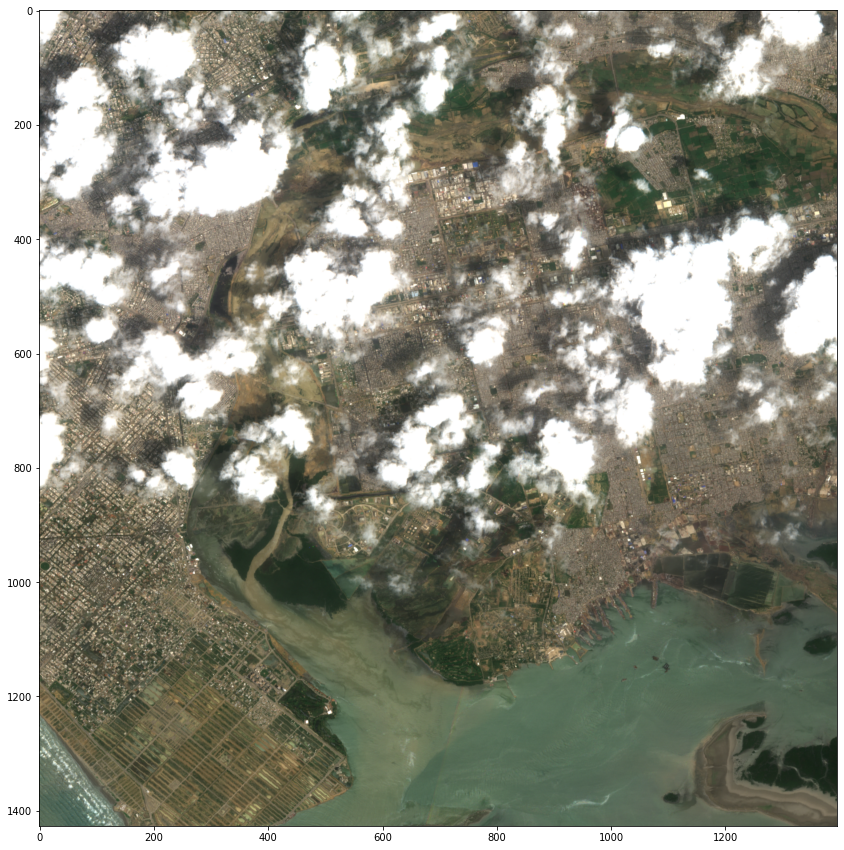

In [43]:
plt.subplots(figsize=(15,15))
plt.imshow(5*rgb)

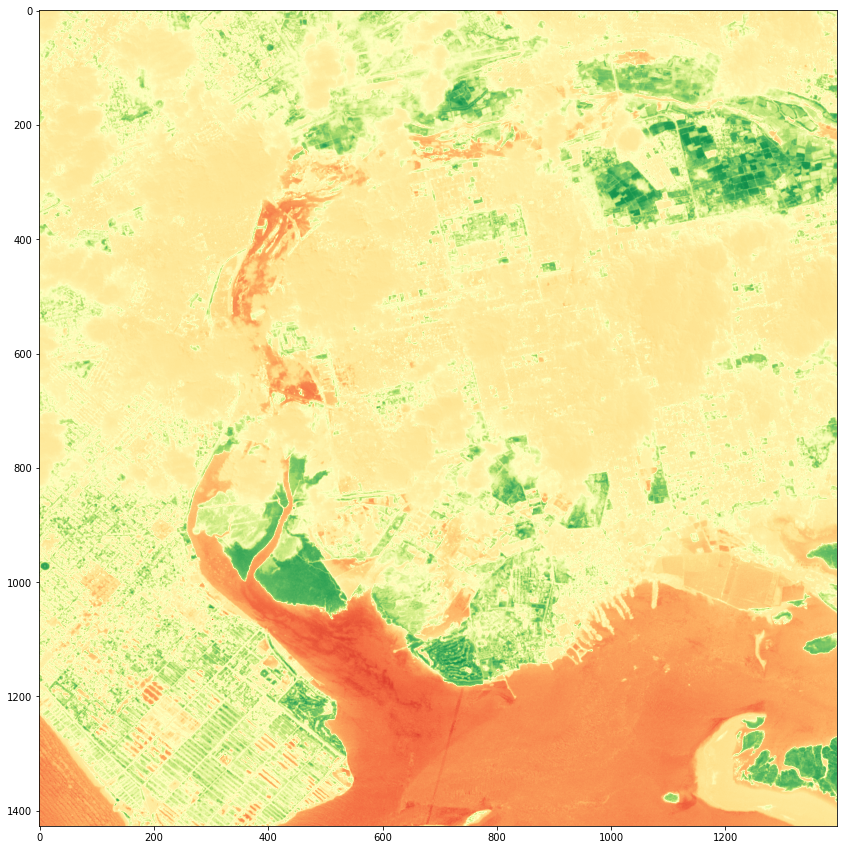

In [31]:
plt.subplots(figsize=(15,15))
plt.imshow(ndvi, cmap='RdYlGn')

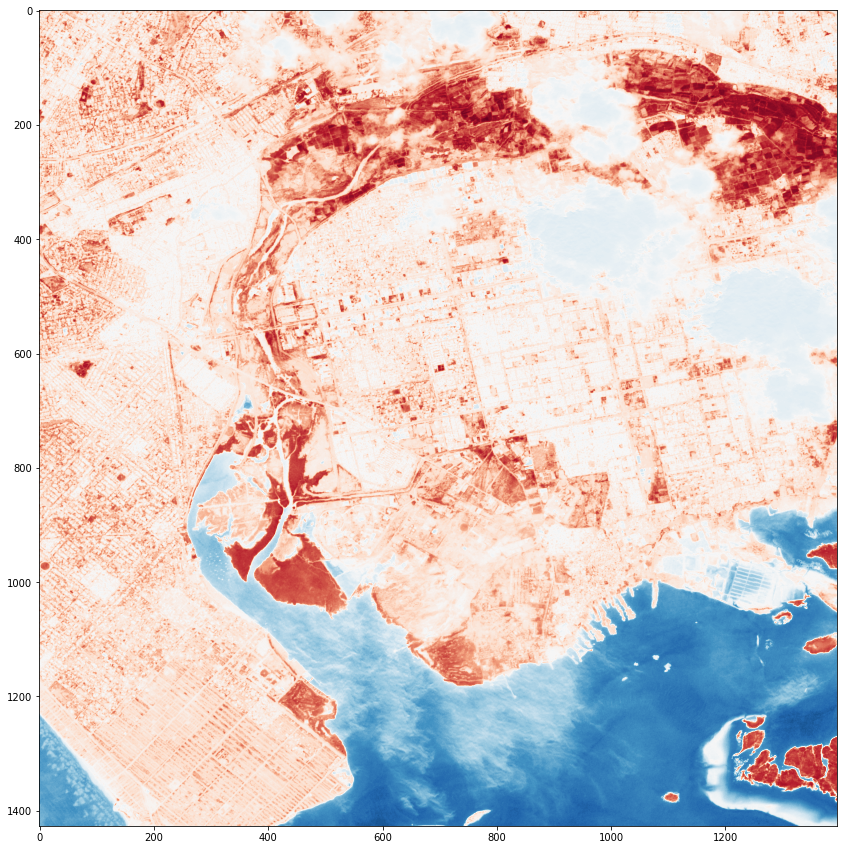

In [ ]:
plt.subplots(figsize=(15,15))
plt.imshow(ndwi, cmap="RdBu")

In [37]:
s2_filepath = "/content/drive/Shared drives/ICG Data Analytics/Data/Pakistan/Karachi/2020-08-01/Sentinel_2_SR/20200829T060639_20200829T060953_T42RUN.tif"

s2_raster = riox.open_rasterio(s2_filepath)[:-1]/10000. # Scaled R, G, B and NIR bands.
cloud_prob_map = riox.open_rasterio(s2_filepath)[-1] # Unscaled cloud probability map.


In [ ]:
rgb = make_rgb_composite(s2_raster)
ndvi = calculate_ndvi(s2_raster)
ndwi = calculate_ndwi(s2_raster)

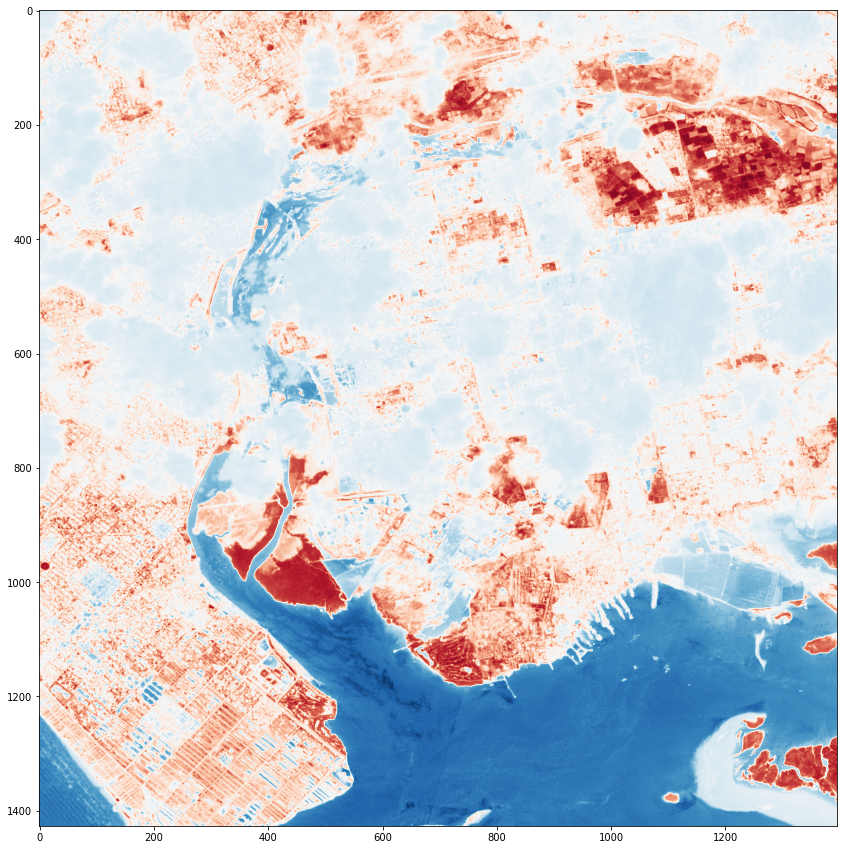

In [32]:
plt.subplots(figsize=(15,15))
plt.imshow(ndwi, cmap="RdBu")

## Plot images on interactive map using Folium

Interactive mapping of geospatial data can be done using the [folium](https://python-visualization.github.io/folium/) package.

Unfortunately Folium doesn't currently play well with colourmaps, which takes ages to run when used. Making custom colourmaps with branca used to work but appears to be currently bugged.

In [40]:
# Obtains the georeferenced image bounds of the raster file and rearranges 
# them to be usable by folium.
lon_min, lat_min, lon_max, lat_max  = s2_raster.rio.bounds()
bounds = [
    [lat_min, lon_min], 
    [lat_max, lon_max]
]

# Specify image instances to be added to the interactive map.
RGB = folium.raster_layers.ImageOverlay(
    name="RGB Composite",
    image=rgb,
    bounds=bounds,
)

NDVI = folium.raster_layers.ImageOverlay(
    name="NDVI",
    image=ndvi.values,
    bounds=bounds,
    # colormap=cm.RdYlGn,
    show=False,
)

NDWI = folium.raster_layers.ImageOverlay(
    name="NDWI",
    image=ndwi.values,
    bounds=bounds,
    #colormap=cm.Blues,
    show=False,
)

In [41]:
# Creates folium map instance centered on the Shamshato Refugee Camp.
m = folium.Map(
    location=[24.819086, 67.1181725], 
    zoom_start= 13,
)


# Adds marker to the map highlighting the location of the Shamshato Refugee Camp.
folium.Marker(
    [24.819086, 67.1181725], 
    tooltip="Karachi"
).add_to(m)

# Adds image instances defined above to the map.
RGB.add_to(m)
NDVI.add_to(m)
NDWI.add_to(m)

folium.LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.